<a href="https://colab.research.google.com/github/cammaral/tn-for-cfd/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ======================================================
# PINN / QPINN / HPINN demo for 1D Burgers
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
import torch as tc
import torch.nn as nn
import pennylane as qml
from pennylane.qnn import TorchLayer

Here we solve the one-dimensional viscuous Burgers equation:
$$\frac{\partial u(x,t)}{\partial t} = -u(x,t)\frac{\partial u(x,t)}{\partial x} + \nu \frac{\partial^2 u(x,t)}{\partial x^2}$$
where $u(x, t)$ is scalar velocity field and $\nu$ is the kinematic viscoscity.

We assume periodic boundary conditions over the domain $[0, 1]$ and time interval $[0, T]$, with intial condition $u(x, 0) = \sin(2\pi x)$. 

We aim to solve it via finite-differences method (FDM), and then train a classical Physics-Informed Neural Network (PINN) and a Hybrid Quantum Physics-Informed Neural Network (HQPINN). We compare the three results, and later verify the efficiency between the PINN and HQPINN by checking its precision (loss) in terms of the numbers of parameters.

First we setup the differential equation and solve it via FDM with a Forward Euler scheme:

In [ ]:
#========================
# Parameters
#========================

L = 1.0
n = 9
N = 2**n
dx = L / (N - 1)
x = np.linspace(0, L, N)
nu=0.01

T = 0.1
dt = 0.0001
tm = np.arange(0, T + dt, dt)

#========================
# Initial condition
#========================
u0 = np.sin(2 * np.pi * x)

#========================
# Differential operators
#========================

D1 = np.zeros((N, N))
for i in range(N):
    D1[i, (i - 1) % N] = -1 / (2 * dx)
    D1[i, (i + 1) % N] =  1 / (2 * dx)

D2 = np.zeros((N, N))
for i in range(N):
    D2[i, i] = -2 / (dx ** 2)
    D2[i, (i - 1) % N] = 1 / (dx ** 2)
    D2[i, (i + 1) % N] = 1 / (dx ** 2)

#========================
# Time-stepping
#========================

Nt = len(tm) # number of steps

u = u0.copy()
for step in range(Nt):
    dudx = D1 @ u
    d2udx2 = D2 @ u
    convection = u * dudx  # Hadamard Product
    diffusion = nu * d2udx2
    u = u + dt * (-convection + diffusion) # New ut
    
# It will be useful to convert variables to torch tensors in order to compute derivatives
def t(arr, req=False, dtype=tc.float32):
    return tc.tensor(arr, dtype=dtype, requires_grad=req) 


We now define the PINN and HQPINN models. The PINN is a pretty standard fully-connected neural network (fcNN), using $\tanh(z)$ as an activation function between layers.

The HQPINN is constituted of pre-processing layer(s), a quantum layer and a post-processing layer before its output. The idea here is simple: quantum circuits are great approximators for harmonic functions, presenting high expressivity with a small amount of parameters. One can then leverage its efficient expressivity by using of classical neural networks as feature maps into the quantum circuit, and post-process the result with another fcNN, generating a model that better captures anharmonic aspects of a function.

In variational ansatz we use angle-cascading, single-qubit rotation gates followed by a cascade of controlled-$R_x$ rotations, that has been shown to be efficient in higher-dimensional fluid dynamics problems. Other ansatz have been tested and are commented out such as strong entangling ansatz. Exploration of other ansatz is highly encouraged, as this is more of an empirical effort.


In [6]:
# -----------------------------
# Architectures
# -----------------------------
class PINN(nn.Module):
    def __init__(self, neurons=5, depth=2, activation=nn.Tanh(), outdim=1):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(2, neurons)])
        self.fcs.extend(nn.Linear(neurons, neurons) for _ in range(depth-1))
        self.out = nn.Linear(neurons, outdim)
        self.act = activation
    def forward(self, xt):
        z = xt
        for fc in self.fcs: z = self.act(fc(z))
        return self.out(z)
    

class HPINN(nn.Module):
    # Classical pre -> quantum -> classical post to scalar.
    def __init__(self, n_qubits=2, q_layers=1, pre_neurons=5, pre_depth=2, activation=nn.Tanh()):
        super().__init__()
        pre = [nn.Linear(2, pre_neurons), activation]
        for _ in range(pre_depth-1): pre += [nn.Linear(pre_neurons, pre_neurons), activation]
        pre += [nn.Linear(pre_neurons, n_qubits)]
        self.pre = nn.Sequential(*pre)
        dev = qml.device("default.qubit", wires=n_qubits)
    # Defining variational ansatz
        def cascade_ansatz(weights, wires):
            n_qubits = len(wires)
            L = 0
            for l in range(q_layers):
                for i in range(n_qubits):
                    qml.RX(weights[l, i, 0], wires=wires[i])
                    qml.RZ(weights[l, i, 1], wires=wires[i])
                for i in range(n_qubits):
                    control = wires[i-1]
                    target = wires[i]
                    qml.ctrl(qml.RX, control=control)(weights[l, i, 2], wires=target)
        @qml.qnode(dev, interface="torch")
        def circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(n_qubits))
            #qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
            #qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            cascade_ansatz(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        self.circuit = circuit 
        self.weight_shape = (q_layers, n_qubits, 3)
        #self.quantum = TorchLayer(circuit, {"weights": (q_layers, n_qubits, 3)})
        self.quantum = TorchLayer(circuit, {"weights": self.weight_shape})
        self.post = nn.Linear(n_qubits, pre_neurons)
        #self.final = nn.Linear(n_qubits, 1)
        self.final = nn.Linear(pre_neurons, 1)

    def forward(self, xt):
        pre_out = self.pre(xt)
        q_out = self.quantum(pre_out)
        post_out = tc.tanh(self.post(q_out)) 
        return self.final(post_out)
    # prints circuit if requested
    def show_circuit(self, sample_input=None):
        if sample_input is None:
            sample_input = tc.zeros(self.pre[-1].out_features)
        q_layers, n_qubits, _ = self.weight_shape
        sample_weights = tc.zeros((q_layers, n_qubits, 3))
        return qml.draw_mpl(self.circuit)(sample_input, sample_weights)


In [7]:
# -----------------------------
# PINN training core (shared)
# -----------------------------
def train_burgers(model,
                  x_col, t_col,
                  x_ic, t_ic, u_ic,
                  x_b0, t_b,  u_b0,
                  x_bL, t_bL, u_bL,
                  nu=1, lr=1e-3, epochs=100,
                  weights=(1.0, 1.0, 1.0, 1.0)):
    """Train any model f((x,t)) -> u with PDE+IC+BC losses (classic PINN loop)."""
    w_pde, w_ic, w_b0, w_bL = weights
    opt = tc.optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for _ in range(epochs):
        u = model(tc.cat([x_col, t_col], dim=1))
        du_dt   = tc.autograd.grad(u, t_col, grad_outputs=tc.ones_like(u), create_graph=True)[0]
        du_dx   = tc.autograd.grad(u, x_col, grad_outputs=tc.ones_like(u), create_graph=True)[0]
        d2u_dx2 = tc.autograd.grad(du_dx, x_col, grad_outputs=tc.ones_like(u), create_graph=True)[0]
        pde = du_dt + u*du_dx - nu*d2u_dx2
        loss_pde = tc.mean(pde**2)

        loss_ic  = tc.mean((model(tc.cat([x_ic, t_ic], dim=1)) - u_ic)**2)
        loss_b0  = tc.mean((model(tc.cat([x_b0, t_b ], dim=1)) - u_b0)**2)
        loss_bL  = tc.mean((model(tc.cat([x_bL, t_bL], dim=1)) - u_bL)**2)

        loss = w_pde*loss_pde + w_ic*loss_ic + w_b0*loss_b0 + w_bL*loss_bL

        opt.zero_grad(); loss.backward(); opt.step()

        # saves loss history (plotting later)
        loss_history.append(loss.item())

    return model, loss_history

def predict(model, x_vec, t_val):
    """Return u(x, t=t_val) as numpy array."""
    x = t(x_vec, False); tfix = t(np.full_like(x_vec, t_val), False)
    with tc.no_grad(): return model(tc.cat([x, tfix], dim=1)).cpu().numpy().reshape(-1,1)

In [8]:
# -----------------------------
# Toy data for 1D Burgers
# -----------------------------
L, Tfin = 1.0, 0.1
dx = L / (N-1)
dt = Tfin / (N-1)

# Initial condition: u(x,0) = sin(pi x)
x_ic = np.linspace(0, L, N).reshape(-1,1)
t_ic = np.zeros_like(x_ic)
u_ic = np.sin(2 * np.pi * x_ic)

# Dirichlet boundaries: u(0,t)=u(L,t)=0
t_b  = np.linspace(0, Tfin, N).reshape(-1,1)
x_b0, x_bL = np.zeros_like(t_b), L*np.ones_like(t_b)
u_b0, u_bL = np.zeros_like(t_b), np.zeros_like(t_b)

# Random collocation points
x_col = np.random.rand(N,1)*L
t_col = np.random.rand(N,1)*Tfin

# Tensors with autograd for x,t
x_col = t(x_col, True); t_col = t(t_col, True)
x_ic  = t(x_ic,  True); t_ic = t(t_ic,  True); u_ic = t(u_ic)
x_b0  = t(x_b0, True);  t_b  = t(t_b,  True);  u_b0 = t(u_b0)
x_bL  = t(x_bL, True);  t_bL = t_b;            u_bL = t(u_bL)

# -----------------------------
# Training parameters
# -----------------------------
epochs = 6000
lr = 1e-3
#lr = 1e-3
activation=nn.Tanh()
x_plot = np.linspace(0, L, 100).reshape(-1,1)


In [9]:
# -----------------------------
# Train & plot: PINN
# -----------------------------
tc.manual_seed(42)
pinn = PINN(neurons=20, depth=4, activation=activation)
pinn, loss_hist = train_burgers(pinn, x_col, t_col, x_ic, t_ic, u_ic,
                                x_b0, t_b, u_b0, x_bL, t_bL, u_bL,
                                nu=nu, lr=lr, epochs=epochs)

u_pinn = predict(pinn, x_plot, 0.1)
# -----------------------------
# Train & plot: HPINN
# -----------------------------
hpinn = HPINN(n_qubits=5, q_layers=1, pre_neurons=20, pre_depth=1, activation=activation)
hpinn, hloss_hist = train_burgers(hpinn, x_col, t_col, x_ic, t_ic, u_ic, x_b0, t_b, u_b0, x_bL, t_bL, u_bL,
                      nu=nu, lr=lr, epochs=epochs)

u_hpinn = predict(hpinn, x_plot, 0.1)

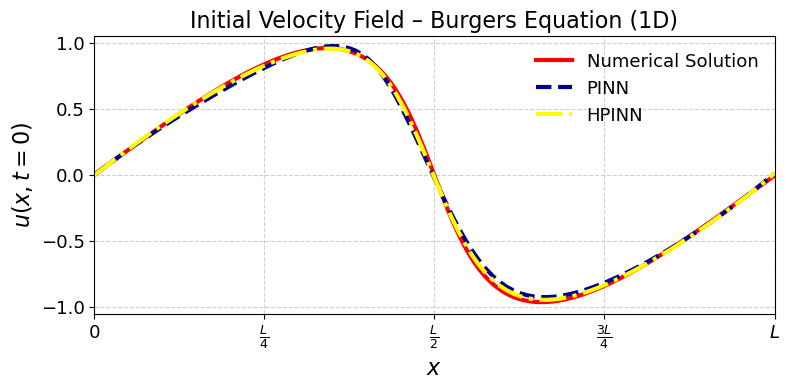

In [10]:
#========================
# PLOT - u(x, 0.1)
#========================

tick_positions = np.linspace(0, L, 5)
tick_labels = [r"$0$", r"$\frac{L}{4}$", r"$\frac{L}{2}$", r"$\frac{3L}{4}$", r"$L$"]

plt.figure(figsize=(8, 4))
plt.plot(x, u, lw=3, c='red', label='Numerical Solution')
plt.plot(x_plot, u_pinn, linewidth=3.0, ls='--', label='PINN', c='darkblue')
plt.plot(x_plot, u_hpinn, linewidth=3.0, ls='-.', label='HPINN', c='#fffb00')

plt.xlim(0, L)
plt.ylim(-1.05, 1.05)

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$u(x, t=0)$', fontsize=16)
plt.title('Initial Velocity Field – Burgers Equation (1D)', fontsize=16)

plt.xticks(tick_positions, tick_labels, fontsize=13)
plt.yticks(np.linspace(-1, 1, 5),fontsize=13)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()


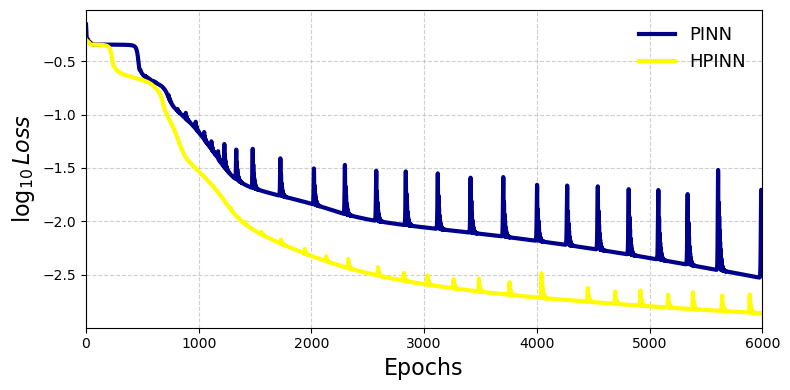

In [11]:
#========================
# PLOT - loss
#========================

plt.figure(figsize=(8, 4))

plt.plot(np.log10(loss_hist), linewidth=3.0, label='PINN', c='darkblue')
plt.plot(np.log10(hloss_hist), linewidth=3.0, label='HPINN', c='#fffb00')

plt.xlim(0, epochs)

plt.xlabel(r'Epochs', fontsize=16)
plt.ylabel(r'$\log_{10}Loss$', fontsize=16)


plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()


In [20]:
# Total number of trainable parameters
print("PINN parameters:", sum(p.numel() for p in pinn.parameters() if p.requires_grad))
print("HPINN parameters:", sum(p.numel() for p in hpinn.parameters() if p.requires_grad))

print("________________________________________\n")
# Trainable parameters per layer
print("PINN parameters per layer: \n")
for name, param in pinn.named_parameters():
    print(name, param.shape, param.numel())
print("________________________________________\n")
print("HQPINN parameters per layer: \n")
for name, param in hpinn.named_parameters():
    print(name, param.shape, param.numel())


PINN parameters: 1341
HPINN parameters: 321
________________________________________

PINN parameters per layer: 

fcs.0.weight torch.Size([20, 2]) 40
fcs.0.bias torch.Size([20]) 20
fcs.1.weight torch.Size([20, 20]) 400
fcs.1.bias torch.Size([20]) 20
fcs.2.weight torch.Size([20, 20]) 400
fcs.2.bias torch.Size([20]) 20
fcs.3.weight torch.Size([20, 20]) 400
fcs.3.bias torch.Size([20]) 20
out.weight torch.Size([1, 20]) 20
out.bias torch.Size([1]) 1
________________________________________

HQPINN parameters per layer: 

pre.0.weight torch.Size([20, 2]) 40
pre.0.bias torch.Size([20]) 20
pre.2.weight torch.Size([5, 20]) 100
pre.2.bias torch.Size([5]) 5
quantum.weights torch.Size([1, 5, 3]) 15
post.weight torch.Size([20, 5]) 100
post.bias torch.Size([20]) 20
final.weight torch.Size([1, 20]) 20
final.bias torch.Size([1]) 1


One can inspect the variational layer by calling its show_circuit() method that prints its gates.

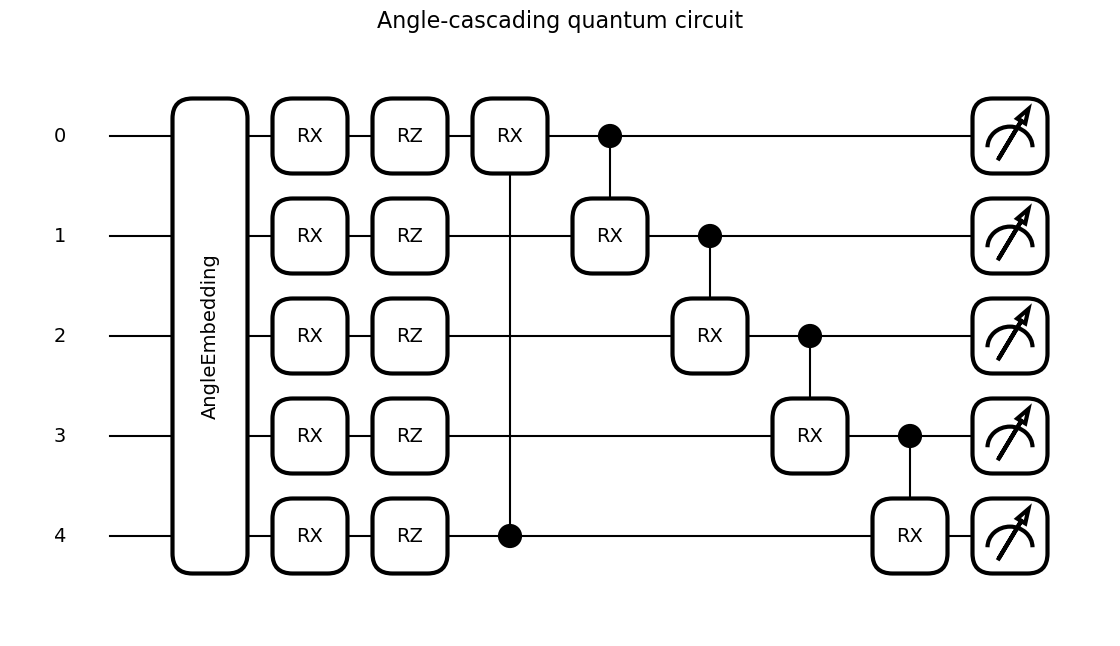

In [ ]:

# Generate the circuit figure
fig_circuit, ax_circuit = hpinn.show_circuit()
ax_circuit.set_title("Angle-cascading quantum circuit", fontsize=16)
#Saves figure as pdf
fig_circuit.savefig("angle.pdf", dpi=300, bbox_inches="tight")
plt.show()

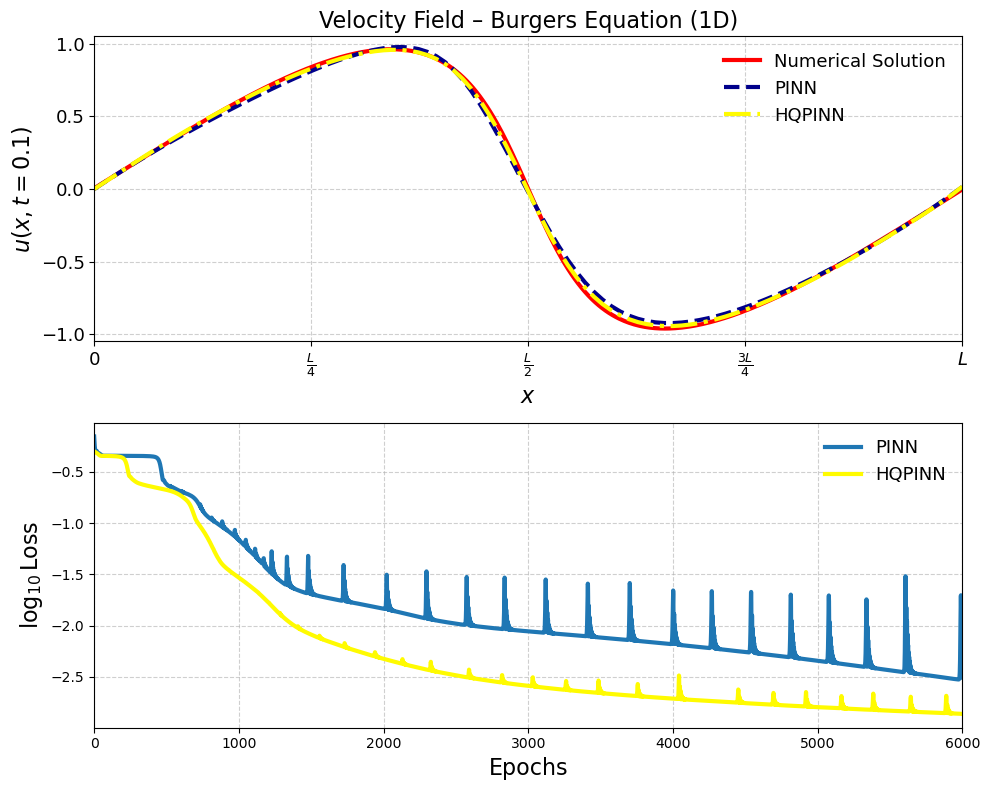

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create ONE figure with 2 rows (subplots)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# --- First subplot (Initial Velocity Field) ---
axs[0].plot(x, u, lw=3, c='red', label='Numerical Solution')
axs[0].plot(x_plot, u_pinn, linewidth=3.0, ls='--', label='PINN', c='darkblue')
axs[0].plot(x_plot, u_hpinn, linewidth=3.0, ls='-.', label='HQPINN', c='#fffb00')

axs[0].set_xlim(0, L)
axs[0].set_ylim(-1.05, 1.05)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[0].set_ylabel(r'$u(x, t=0.1)$', fontsize=16)
axs[0].set_title('Velocity Field – Burgers Equation (1D)', fontsize=16)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(tick_labels, fontsize=13)
axs[0].set_yticks(np.linspace(-1, 1, 5))
axs[0].tick_params(axis='y', labelsize=13)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend(fontsize=13, frameon=False)

# --- Second subplot (Loss History) ---
axs[1].plot(np.log10(loss_hist), linewidth=3.0, label='PINN')
axs[1].plot(np.log10(hloss_hist), linewidth=3.0, label='HQPINN', c='#fffb00')
axs[1].set_xlim(0, epochs)
axs[1].set_xlabel(r'Epochs', fontsize=16)
axs[1].set_ylabel(r'$\log_{10}\mathrm{Loss}$', fontsize=16)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend(fontsize=13, frameon=False)

# Adjust layout and save
plt.tight_layout()
plt.savefig("burgers_pinn_hpinn.pdf", dpi=300)
plt.show()


In [14]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

with PdfPages("burgers_pinn_hpinn.pdf") as pdf:
    # --- First figure ---
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, lw=3, c='red', label='Numerical Solution')
    plt.plot(x_plot, u_pinn, linewidth=3.0, ls='--', label='PINN', c='darkblue')
    plt.plot(x_plot, u_hpinn, linewidth=3.0, ls='-.', label='HPINN', c='#fffb00')

    plt.xlim(0, L)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$u(x, t=0.1)$', fontsize=16)
    plt.title('Velocity Field – Burgers Equation (1D)', fontsize=16)
    plt.xticks(tick_positions, tick_labels, fontsize=13)
    plt.yticks(np.linspace(-1, 1, 5), fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=13, frameon=False)
    plt.tight_layout()
    pdf.savefig(dpi=300)   # save this figure into PDF
    plt.close()

    # --- Second figure ---
    plt.figure(figsize=(8, 4))
    plt.plot(np.log10(loss_hist), linewidth=3.0, label='PINN')
    plt.plot(np.log10(hloss_hist), linewidth=3.0, label='HPINN', c='#fffb00')

    plt.xlim(0, epochs)
    plt.xlabel(r'Epochs', fontsize=16)
    plt.ylabel(r'$\log_{10}\mathrm{Loss}$', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=13, frameon=False)
    plt.tight_layout()
    pdf.savefig(dpi=300)
    plt.close()
    

    ##### Third figure
    fig, ax = hpinn.show_circuit()
    ax.set_title("Angle-cascading quantum circuit", fontsize=16)
    #plt.tight_layout()
    pdf.savefig(dpi=300)
    plt.close()


In [15]:

print(loss_hist[-1], "\n")
print(hloss_hist[-1])

0.0033135192934423685 

0.001371901948004961


In [16]:

loss_hist[-1]/hloss_hist[-1]

2.4152741369461093